# L9 HW: Perceptual Loss for Real-Time Style Transfer

FADL2 Cutting Edge Deep Learning

Lesson 9 HW: Perceptual Loss for Real-Time Style Transfer

SEP 08 2017 - WH Nixalo

**NOTE: this should more/less follow along w/ the 'Reflection Padding' section under 'Fast Style Transfer' in the neural-style Lesson 9 JNB.**

### Imports / Setup

In [1]:
%matplotlib inline
import os, sys; sys.path.insert(1, os.path.join('../utils'))
from utils2 import *
from vgg16_avg import VGG16_Avg
from bcolz_array_iterator import BcolzArrayIterator

limit_mem()

Using TensorFlow backend.
/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
path = '../data/'
dirpath = path + 'lesson9/style-test/'

### Pre-De-Processing for VGG model: 

In [3]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,1,3))
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

### Function Definitions:

In [30]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x) if act else x

def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(ip, nf, 3, (1,1), act=False)
    return merge([x, ip], mode='sum')

def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Convolution2D(filters, size, size, border_mode='same')(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)

#### The Perceptual (Content) Loss Function ####
def get_outp(m, λn): return m.get_layer(f'block{λn}_conv1').output

def mean_sqr_b(diff):
    dims = list(range(1, K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

def content_fn(x):
    res = 0; n = len(w)
    for i in range(n): res += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return res
#### #### #### #### #### #### #### #### #### ####

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1,1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)
    def get_output_shape_for(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad, h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad, h_pad], [w_pad, w_pad], [0,0]], 'REFLECT')
    
def res_crop_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1), 'valid')
    x = conv_block(x,  nf, 3, (1,1), 'valid', False)
    ip = Lambda(lambda x: x[:, 2:-2, 2:-2])(ip)
    return merge([x, ip], mode='sum')

# there was talk about removing the final activation and lambda layer; so I'm doing that here
def get_model(shp):
    inp = Input(shp)
    x = ReflectionPadding2D((40, 40))(inp)
    x = conv_block(x, 64, 9, (1,1))
    x = conv_block(x, 64, 3)
    x = conv_block(x, 64, 3)
    for i in range(5): x = res_crop_block(x)
    x = up_block(x, 64, 3)
    x = up_block(x, 64, 3)
    x = Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
    outp = Lambda(lambda x: (x+1)*127.5)(x)
    return inp, outp

### Bcolz -- Batched Data Array Iterating:

In [29]:
# question I have is what to do with the target parameter: 1 long zerod-array,
# or a batch-sized zerod-array?
#     targ = np.zeros((arr_hr.shape[0], 1))
#     targ = np.zeros((bs, 1))

def train(bs, niter=10):
    targ = np.zeros((bs, 1))
    bc = BcolzArrayIterator(arr_hr_c6, arr_lr_c6, batch_size=bs)
    for i in range(niter):
        hr, lr = next(bc)
        model.train_on_batch(lr[:bs], hr[:bs], targ[:len(hr)])    

### Model:

In [19]:
arr_lr_c6 = bcolz.open(path + 'trn_resized_72_c6.bc')
arr_hr_c6 = bcolz.open(path + 'trn_resized_288_c6.bc')

pars = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

In [ ]:
shp = arr_hr_c6[0].shape # same as: arr_hr_c6.shape[1:]

style_img = Image.open(dirpath + 'alena-aenami-eclipse-1k-square.jpg')
style_img = np.array(style)[:shp[0], :shp[1], :shp[2]]

inp, outp = get_model(shp)




### Test:

In [6]:
%ls $dirpath

4cf708972aca0466d1edd5731b5096fa--caucasus-central.jpg
4cf708972aca0466d1edd5731b5096fa--caucasus-central-square.jpg
alena-aenami-eclipse-1k.jpg
alena-aenami-eclipse-1k-square.jpg


In [7]:
style_img = Image.open(dirpath + 'alena-aenami-eclipse-1k-square.jpg')
targt_img = Image.open(dirpath + '4cf708972aca0466d1edd5731b5096fa--caucasus-central-square.jpg')

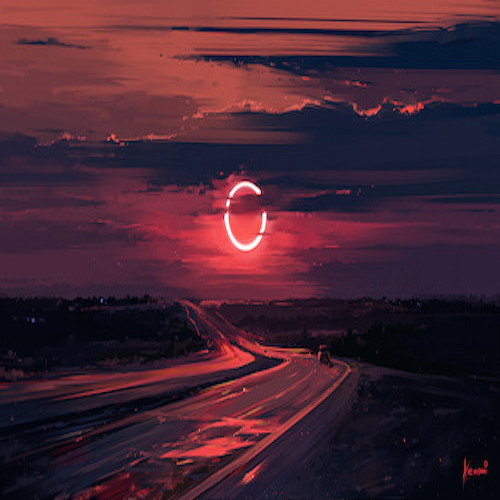

In [8]:
style_img

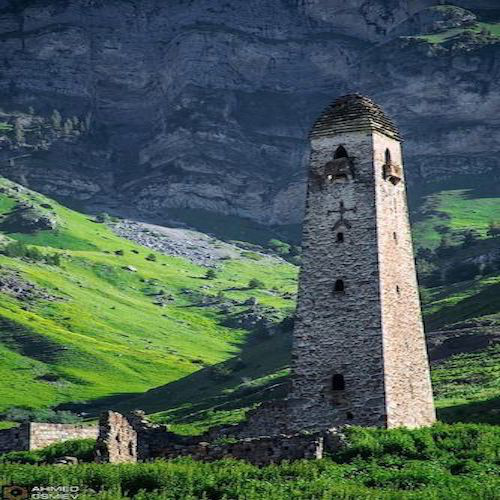

In [9]:
targt_img

In [ ]:
inp = 